# Reading data

In [1]:
!pip install pyspark
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Heart Disease Analysis") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("heart_2022_no_nans.csv", header=True, inferSchema=True)

# Show the first few rows and columns of the dataframe to understand the structure
df.show(5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 446.0 kB/s eta 0:00:0000:0100:07
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 844.6 kB/s eta 0:00:00a 0:00:01
  DEPRECATION: pyspark is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for pyspark ... done


24/05/27 00:05:45 WARN Utils: Your hostname, osboxes resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/05/27 00:05:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/27 00:05:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/27 00:06:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+--------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|        RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBath

# Analytical queries

In [18]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, when

# Query 1: Average age of patients who have heart disease versus patients who do not have heart disease

# Mapping AgeCategory to Numeric Values
df = df.withColumn('AgeNumeric', 
                   when(col('AgeCategory') == 'Age 18 to 24', 21)
                   .when(col('AgeCategory') == 'Age 25 to 29', 27)
                   .when(col('AgeCategory') == 'Age 30 to 34', 32)
                   .when(col('AgeCategory') == 'Age 35 to 39', 37)
                   .when(col('AgeCategory') == 'Age 40 to 44', 42)
                   .when(col('AgeCategory') == 'Age 45 to 49', 47)
                   .when(col('AgeCategory') == 'Age 50 to 54', 52)
                   .when(col('AgeCategory') == 'Age 55 to 59', 57)
                   .when(col('AgeCategory') == 'Age 60 to 64', 62)
                   .when(col('AgeCategory') == 'Age 65 to 69', 67)
                   .when(col('AgeCategory') == 'Age 70 to 74', 72)
                   .when(col('AgeCategory') == 'Age 75 to 79', 77)
                   .when(col('AgeCategory') == 'Age 80 or older', 82)
                   .otherwise(None))

df.select('AgeCategory', 'AgeNumeric').show(5)

avg_age_with_hd = df.filter(df['HadHeartAttack'] == 'Yes').select('AgeNumeric').groupBy().avg().collect()[0][0]
avg_age_without_hd = df.filter(df['HadHeartAttack'] == 'No').select('AgeNumeric').groupBy().avg().collect()[0][0]

print(f"Average age of patients with heart disease: {avg_age_with_hd}")
print(f"Average age of patients without heart disease: {avg_age_without_hd}")


+---------------+----------+
|    AgeCategory|AgeNumeric|
+---------------+----------+
|   Age 65 to 69|        67|
|   Age 70 to 74|        72|
|   Age 75 to 79|        77|
|Age 80 or older|        82|
|Age 80 or older|        82|
+---------------+----------+
only showing top 5 rows



Average age of patients with heart disease: 67.99962783773725
Average age of patients without heart disease: 54.81721678339718


In [3]:
# Query 2: Percentage of Smoker with Heart Desease

# Calculate the total number of patients who smoke
total_hd_patients = df.filter(col('SmokerStatus').startswith('Current smoker')).count()

# Calculate the number of smokers with heart disease
smokers_with_hd = df.filter((df['HadHeartAttack'] == 'Yes') & (col('SmokerStatus').startswith('Current smoker'))).count()

# Calculate the percentage
percentage_smokers_hd = (smokers_with_hd / total_hd_patients) * 100

print(f"Percentage of smokers who have heart disease: {percentage_smokers_hd:.2f}%")

Percentage of smokers who have heart disease: 7.91%


In [4]:
# Query 3: Percentage of alcohol consumers who have heart disease


# Calculate the total number of patients with heart disease
total_hd_patients = df.filter(df['HadHeartAttack'] == 'Yes').count()

# Calculate the number of alcohol consumers with heart disease
alcohol_consumers_hd = df.filter((df['HadHeartAttack'] == 'Yes') & (df['AlcoholDrinkers'] == 'Yes')).count()

# Calculate the percentage
percentage_alcohol_hd = (alcohol_consumers_hd / total_hd_patients) * 100

print(f"Percentage of alcohol consumers who have heart disease: {percentage_alcohol_hd:.2f}%")

Percentage of alcohol consumers who have heart disease: 39.64%


In [5]:
#Query 4: BMI Difference of Patients with and without Heart Disease

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Heart Disease Analysis") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("heart_2022_no_nans.csv", header=True, inferSchema=True)

# Calculate average BMI for patients with heart disease
avg_bmi_heart_disease = df.filter(df['HadHeartAttack'] == 'Yes').agg(avg("BMI")).collect()[0][0]

# Calculate average BMI for patients without heart disease
avg_bmi_no_heart_disease = df.filter(df['HadHeartAttack'] == 'No').agg(avg("BMI")).collect()[0][0]

print(f"Average BMI for patients with heart disease: {avg_bmi_heart_disease}")
print(f"Average BMI for patients without heart disease: {avg_bmi_no_heart_disease}")


Average BMI for patients with heart disease: 29.492435429847426
Average BMI for patients without heart disease: 28.620521482284047


In [6]:
#Query 5: Average Sleeping Time Difference of Patients with and without Heart Disease

# Calculate average sleeping time for patients with heart disease
avg_sleep_heart_disease = df.filter(df['HadHeartAttack'] == 'Yes').agg(avg("SleepHours")).collect()[0][0]

# Calculate average sleeping time for patients without heart disease
avg_sleep_no_heart_disease = df.filter(df['HadHeartAttack'] == 'No').agg(avg("SleepHours")).collect()[0][0]

print(f"Average sleeping time for patients with heart disease: {avg_sleep_heart_disease}")
print(f"Average sleeping time for patients without heart disease: {avg_sleep_no_heart_disease}")


Average sleeping time for patients with heart disease: 7.043096390026052
Average sleeping time for patients without heart disease: 7.020074208790689


In [7]:
#Query 6: Percentage of Patients with Heart Disease Who Partake in Physical Activity

# Calculate total number of patients with heart disease
total_heart_disease = df.filter(df['HadHeartAttack'] == 'Yes').count()

# Calculate number of patients with heart disease who partake in physical activity
active_heart_disease = df.filter((df['HadHeartAttack'] == 'Yes') & (df['PhysicalActivities'] == 'Yes')).count()

# Calculate the percentage
percentage_active_heart_disease = (active_heart_disease / total_heart_disease) * 100

print(f"Percentage of patients with heart disease who partake in physical activity: {percentage_active_heart_disease:.2f}%")


Percentage of patients with heart disease who partake in physical activity: 63.37%


# Machine learning model

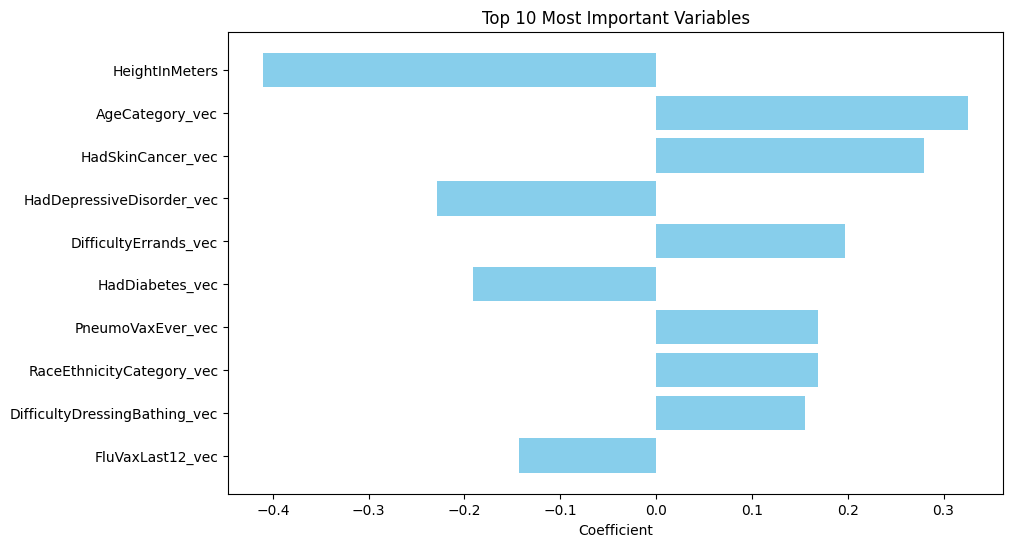

+-------------------+------------------+
|             Metric|             Value|
+-------------------+------------------+
|       AvgAgeWithHD| 67.99962783773725|
|    AvgAgeWithoutHD| 54.81721678339718|
|PercentageSmokersHD| 7.910477854694537|
|PercentageAlcoholHD|  39.6427242277633|
|       AvgBMIWithHD|29.492435429847426|
|         AvgBMINoHD|28.620521482284047|
|     AvgSleepWithHD| 7.043096390026052|
|       AvgSleepNoHD| 7.020074208790689|
| PercentageActiveHD|63.371790100483814|
|            ROC_AUC|0.8912801060851364|
|           Accuracy| 0.949528744542821|
|        Sensitivity|0.2606516290726817|
|        Specificity|0.9890561859154119|
+-------------------+------------------+

+--------------------+--------------------+
|             Feature|         Coefficient|
+--------------------+--------------------+
|  PhysicalHealthDays|-0.00197726287962...|
|    MentalHealthDays|0.001092659136079...|
|          SleepHours|-0.02368773788364031|
|      HeightInMeters|-0.4099496167202

In [20]:
!pip install numpy matplotlib pandas
from pyspark.sql.functions import when, col, avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pandas as pd

df = spark.read.csv("heart_2022_no_nans.csv", header=True, inferSchema=True)

# Convert 'HadHeartAttack' to numerical
df = df.withColumn('HadHeartAttackNumeric', when(col('HadHeartAttack') == 'Yes', 1).otherwise(0))

# Identify categorical columns
categorical_cols = [col for col, dtype in df.dtypes if dtype == 'string' and col != 'HadHeartAttack']

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_cols]

# Apply indexers and encoders
for indexer in indexers:
    df = indexer.fit(df).transform(df)
for encoder in encoders:
    df = encoder.fit(df).transform(df)

# List of all columns excluding the target and original categorical columns
feature_cols = [col for col in df.columns if col not in categorical_cols + ['HadHeartAttack', 'HadHeartAttackNumeric'] and not col.endswith("_index")]

# Assemble all features into a feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Select final dataset with features and label
final_df = df.select("features", "HadHeartAttackNumeric")

# Split the data into training and test sets
train_df, test_df = final_df.randomSplit([0.7, 0.3], seed=42)

# Initialize and train the logistic regression model
lr = LogisticRegression(labelCol="HadHeartAttackNumeric")
lr_model = lr.fit(train_df)

# Make predictions on the test set
predictions = lr_model.transform(test_df)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="HadHeartAttackNumeric", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

# Calculate accuracy, sensitivity, and specificity
predictions = predictions.withColumn("prediction", when(col("prediction") >= 0.5, 1).otherwise(0))
tp = predictions.filter((predictions['prediction'] == 1) & (predictions['HadHeartAttackNumeric'] == 1)).count()
tn = predictions.filter((predictions['prediction'] == 0) & (predictions['HadHeartAttackNumeric'] == 0)).count()
fp = predictions.filter((predictions['prediction'] == 1) & (predictions['HadHeartAttackNumeric'] == 0)).count()
fn = predictions.filter((predictions['prediction'] == 0) & (predictions['HadHeartAttackNumeric'] == 1)).count()

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Prepare results DataFrame
results = spark.createDataFrame([
    ("AvgAgeWithHD", avg_age_with_hd),
    ("AvgAgeWithoutHD", avg_age_without_hd),
    ("PercentageSmokersHD", percentage_smokers_hd),
    ("PercentageAlcoholHD", percentage_alcohol_hd),
    ("AvgBMIWithHD", avg_bmi_heart_disease),
    ("AvgBMINoHD", avg_bmi_no_heart_disease),
    ("AvgSleepWithHD", avg_sleep_heart_disease),
    ("AvgSleepNoHD", avg_sleep_no_heart_disease),
    ("PercentageActiveHD", percentage_active_heart_disease),
    ("ROC_AUC", roc_auc),
    ("Accuracy", accuracy),
    ("Sensitivity", sensitivity),
    ("Specificity", specificity)
], ["Metric", "Value"])

# Extract coefficients
coefficients = lr_model.coefficients
intercept = lr_model.intercept

# Combine coefficients with feature names
coef_df = spark.createDataFrame([(feature, float(coef)) for feature, coef in zip(feature_cols, coefficients)], ["Feature", "Coefficient"])

# Convert Spark DataFrame to Pandas DataFrame
coef_pd_df = coef_df.toPandas()

# Calculate the absolute values of the coefficients
coef_pd_df['abs_coeff'] = coef_pd_df['Coefficient'].abs()

# Sort by absolute coefficient values to get the top 10 features
top_10_features = coef_pd_df.sort_values(by='abs_coeff', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Top 10 Most Important Variables')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest coefficient on top
plt.show()

results.show()
coef_df.show()